In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
import pdb

In [4]:
import torch
print(torch.__version__)
torch.cuda.set_device(0)

0.3.1.post2


In [5]:
torch.backends.cudnn.benchmark=True

## Data

In [6]:
from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse
    

class cust_loss(torch.nn.Module):  
    def __init__(self):
        super(cust_loss, self).__init__()
        
    def forward(self, input,target):
       # print(type(input), type(target))
        loss = self.lovasz_hinge(input, target)
        return loss
        
    def lovasz_grad(self,gt_sorted):
        """
        Computes gradient of the Lovasz extension w.r.t sorted errors
        See Alg. 1 in paper
        """
        p = len(gt_sorted)
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        jaccard = 1. - intersection / union
        if p > 1: # cover 1-pixel case
            jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
        return jaccard

    def lovasz_hinge(self,logits, labels, per_image=True, ignore=None):
        """
        Binary Lovasz hinge loss
          logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
          labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
          per_image: compute the loss per image instead of per batch
          ignore: void class id
        """
        #if per_image:
      #  pdb.set_trace()
        loss = self.mean(self.lovasz_hinge_flat(*self.flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                              for log, lab in zip(logits, labels))
#         else:
#             loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
        return loss


    def lovasz_hinge_flat(self,logits, labels):
        """
        Binary Lovasz hinge loss
          logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
          labels: [P] Tensor, binary ground truth labels (0 or 1)
          ignore: label to ignore
        """
        if len(labels) == 0:
            # only void pixels, the gradients should be 0
            return logits.sum() * 0.
        signs = 2. * labels.float() - 1.
        errors = (1. - logits * (signs))
        errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
        perm = perm.data
        gt_sorted = labels[perm]
        grad = self.lovasz_grad(gt_sorted)
        loss = torch.dot(F.elu(errors_sorted)+1, (grad))
        return loss
    
    def flatten_binary_scores(self,scores, labels, ignore=None):
        """
        Flattens predictions in the batch (binary case)
        Remove labels equal to 'ignore'
        """
        scores = scores.view(-1)
        labels = labels.view(-1)
        if ignore is None:
            return scores, labels
        valid = (labels != ignore)
        vscores = scores[valid]
        vlabels = labels[valid]
        return vscores, vlabels
    def mean(self,l, ignore_nan=False, empty=0):
        """
        nanmean compatible with generators.
        """
        l = iter(l)
        if ignore_nan:
            l = ifilterfalse(np.isnan, l)
        try:
            n = 1
            acc = next(l)
        except StopIteration:
            if empty == 'raise':
                raise ValueError('Empty mean')
            return empty
        for n, v in enumerate(l, 2):
            acc += v
        if n == 1:
            return acc
        return acc / n

In [7]:
PATH = Path('D:/data/TGS')
MASKS_FN = 'train.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
#meta_csv = pd.read_csv(PATH/META_FN)

In [8]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [9]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [10]:
TRAIN_DN = PATH/'train/images'
MASKS_DN = PATH/'train/masks'
test = PATH/'test/images'
sz = 128
bs = 40
nw = 16

In [11]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert((len(fnames))==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [12]:
x_names = np.array([Path(TRAIN_DN)/f'{o}.png' for o in masks_csv['id']])
y_names = np.array([Path(MASKS_DN)/f'{o}.png' for o in masks_csv['id']])
        

In [13]:
x_names.shape


(4000,)

In [14]:
# x_names = np.array([Path(TRAIN_DN)/f'{o}.png' for o in masks_csv['id']])
# y_names = np.array([Path(MASKS_DN)/f'{o}.png' for o in masks_csv['id']])
t_names=np.array([Path(test)/f'{o}' for o in os.listdir(test)])
# t_names.shape

In [15]:
val_idxs = list(range(500))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
trn_x.shape
trn_y.shape

(3500,)

In [16]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [17]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms,test=(t_names,t_names) ,path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [19]:
x,y = next(iter(md.trn_dl))

In [20]:
x.shape,y.shape

(torch.Size([40, 3, 128, 128]), torch.Size([40, 128, 128]))

In [21]:
y[0][:][:]


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 128x128 (GPU 0)]

## Simple upsample

In [23]:
f = resnet34
cut,lr_cut = model_meta[f]

In [24]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [25]:
def IOU(pred, targs):
    pred = (pred>0).float()
    dice =  (pred*targs).sum() / (pred+targs).sum()
    return dice

def IOU(pred, targ):
    print(type(pred, targ)
    pred = (pred>0).float()
    dice = np.sum((np.logical_and(pred, targ)+0.0001) / (np.logical_or(pred, targ))+0.0001)
    return dice

In [26]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [27]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [28]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [29]:
m_base = get_base()

In [30]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [31]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.SGD
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),IOU]

In [32]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   IOU                                                                        
    0      0.609377   89.381257  0.603043   0.07247   



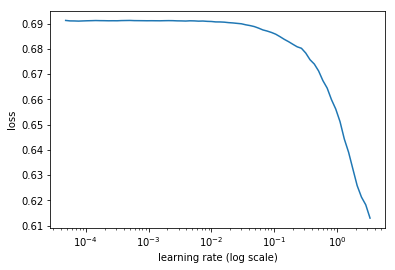

In [33]:
learn.lr_find()
learn.sched.plot()

In [34]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [35]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   IOU                                                                        
    0      0.631941   0.594411   0.756048   0.030099  
    1      0.521956   0.423649   0.835174   0.302796                                                                   
    2      0.394405   0.33395    0.866977   0.346353                                                                   
    3      0.323748   0.30071    0.887075   0.379099                                                                   



[array([0.30071]), 0.887075068950653, 0.3790991242327289]

In [36]:
learn.save('tmp')

In [37]:
learn.load('tmp')

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   IOU                                                                        
    0      0.274593   0.275929   0.889948   0.377244  
    1      0.249531   0.258714   0.897569   0.388394                                                                   
    2      0.239902   0.252504   0.901776   0.394581                                                                   
    3      0.226894   0.249679   0.901915   0.394869                                                                   



[array([0.24968]), 0.901914918422699, 0.3948686790502473]

In [40]:
learn.save('128')

In [41]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

## U-net (ish)

In [44]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [45]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
     #   self.drop = nn.Dropout2d(p=0.5)
        self.bn = nn.BatchNorm2d(n_out)

    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
       # pdb.set_trace()
        print("x_p",x_p.size())
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))  
       

In [46]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,260,256)
        self.up2 = UnetBlock(256,132,128)
        self.up3 = UnetBlock(128,64,128)
        self.up4 = UnetBlock(128,64,128)
        self.up5 = nn.ConvTranspose2d(128,1, 2, stride=2)                   
       # pdb.set_trace()
        self.up6 = nn.Conv2d(1,1,kernel_size=1,padding=0)
        self.upn = nn.ReLU(nn.ConvTranspose2d(512,1,1,stride =1))
        self.logit = nn.Sequential(nn.Conv2d(641,64,kernel_size=3,padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.ConvTranspose2d(64,1,kernel_size=1,padding=0))
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        #print("size of x", type(x))
        print("sfs 3 ",self.sfs[3].features.size())
        xtt = []
        xt = torch.split(self.sfs[3].features,64,dim=1)
      #  print("xt type", xt[0].size())
       # xtt = F.conv2d(self.sfs[0].features,xt[0].contiguous(),padding=1,stride=4)
        for i in range(0,len(xt)):  
            xt_new= torch.sum(xt[i],0)
            xt_new1 = xt_new.unsqueeze(0)
            xt1 = F.relu(F.conv2d(self.sfs[0].features,xt_new1.contiguous(),stride=8),inplace=True)
         #   print("xt1", xt1.size())
            xtt.append(xt1)
        xtt_1 = torch.cat([xtt[0],xtt[1],xtt[2],xtt[3]],1)
        xtt_2 = torch.cat((xtt_1, self.sfs[3].features),1)
        x3 = self.up1(x, xtt_2)
        #print("sfs3 deatures", self.sfs[3].features.size())
        print("x-afet up1",x3.size())
        xtt = []
        for i in range(0,len(xt)):  
            xt_new= torch.sum(xt[i],0)
            xt_new1 = xt_new.unsqueeze(0)
            xt1 = F.relu(F.conv2d(self.sfs[1].features,xt_new1.contiguous(),stride=2,padding=3),inplace=True)
        #    print("xt 1", xt1.size())
            xtt.append(xt1)
        xtt_3 = torch.cat([xtt[0],xtt[1],xtt[2],xtt[3]],1)
        print("xtt 3", xtt_3[0].size())
#         print("xttt 3", xtt_3.size())
        xtt_4 = torch.cat((xtt_3, self.sfs[2].features),1)
        x2 = self.up2(x3, xtt_4)
        xtt = []
        xt = torch.split(self.sfs[3].features,128,dim=1)
        for i in range(0,len(xt)):  
            xt_new= torch.sum(xt[i],0)
            xt_new1 = xt_new.unsqueeze(0)
            print("sfs 2", self.sfs[2].features.size())
            print("xt_new1", xt_new1.size())
            xt1 = F.relu(F.conv2d(self.sfs[2].features,xt_new1.contiguous(),padding=3),inplace=True)
            xt1 = F.upsample(xt1,size=(16,16),mode='bilinear')
            print("xt 1", xt1.size())
            xtt.append(xt1)
        xtt_5 = torch.cat([xtt[0],xtt[1]],1)
        print("xtt ", xtt_5[0].size())
#         print("xttt 3", xtt_3.size())
        xtt_6 = torch.cat((xtt_5, self.sfs[2].features),1)
        x1 = self.up3(x2, self.sfs[1].features)
        x0 = self.up4(x1, self.sfs[0].features)  
        x00 = self.up5(x0)
       # print("x00", x00.size())
        concated = torch.cat((x00,
                        F.upsample(x0, scale_factor=2,mode="bilinear"),
                        F.upsample(x1, scale_factor=4,mode="bilinear"),
                        F.upsample(x2, scale_factor=8,mode="bilinear"),
                        F.upsample(x3, scale_factor=16,mode="bilinear")
                      ),1)
        print("after concat", concated.size())
        x = self.logit(concated)
        x = F.dropout(x,p=0.75)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [47]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]
    

class dice_loss(torch.nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()


    def forward(self, input, target):
        input = torch.sigmoid(input)
        smooth = 1.

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                  (iflat.sum() + tflat.sum() + smooth))

In [48]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                  #  nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                   # nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(3, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
       # print(one_by_one[:,0:1].shape)
        return one_by_one[:,0:1]
    
model = Unet()
model.cuda();
opt = optim.Adam(model.parameters(), 0.005)
model.parameters
crit=cust_loss()
metrics=[accuracy_thresh(0.5),IOU]
fit(model, md, 80, opt, crit, metrics)






epoch      trn_loss   val_loss   <lambda>   IOU                                                                        
    0      2.000958   2.000146   0.755723   0.194473  
    1      2.000472   2.001492   0.755723   0.195664                                                                   
    2      2.000451   2.00017    0.755723   0.195664                                                                   
    3      2.000407   2.000512   0.755723   0.0                                                                        
    4      2.000404   2.000125   0.755723   0.0                                                                        
    5      2.000329   2.000069   0.755723   0.195664                                                                   
    6      2.000263   2.000458   0.755723   0.195664                                                                   
    7      2.000299   2.000432   0.755723   0.0                                                          

    67     2.000283   2.000698   0.755723   0.195664                                                                   
    68     2.000254   2.000148   0.755723   0.195664                                                                   
    69     2.000212   2.000363   0.755723   0.0                                                                        
    70     2.000196   2.000176   0.755723   0.195664                                                                   
    71     2.000226   2.000265   0.755723   0.0                                                                        
    72     2.000291   2.000071   0.755723   0.0                                                                        
    73     2.00043    2.000223   0.755723   0.0                                                                        
    74     2.000382   2.000033   0.755723   0.0                                                                        
    75     2.000295   2.000032   0.75572

[array([2.00028]), 0.7557226634025573, 0.0]

In [49]:
pickle.dump(model, open("test",'wb'))

In [ ]:
pickle.load(open("test",'rb'))

In [ ]:

m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=cust_loss()
learn.metrics=[accuracy_thresh(0.5),IOU]
# learn.crit

# learn.lr_find(0.001,0.1)
# learn.sched.plot()

In [ ]:
learn.fit(lrs,1,cycle_len=50,use_clr=(5,8))

In [ ]:
learn.save('128urn-logit')
learn.load('128urn-logit')

In [ ]:
learn.save('128urn-logit_tmp')
learn.load('128urn-logit_tmp')

In [ ]:
learn.fit(lrs,10,wds=wd)

In [ ]:
learn.fit(lrs,50,wds=wd)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=cust_loss()
learn.metrics=[accuracy_thresh(0.5),IOU]
learn.crit

In [ ]:
#learn.save_fc1()


In [ ]:
[o.features.size() for o in m.sfs]

In [ ]:
learn.freeze_to(1)

In [ ]:

learn.lr_find(0.008,0.1)
learn.sched.plot()

In [ ]:
lr=8e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])
lr

In [ ]:
learn.fit(lr,1,cycle_len=10,use_clr=(5,8))

In [ ]:
del learn
del models

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs,1,wds=wd,cycle_len=50,use_clr=(20,8))

In [ ]:
lr=1e-1
wd=1e-4

lrs = np.array([lr/100,lr/10,lr])
lr


In [ ]:
learn.save('128urn-k1')

In [ ]:
learn.load('128urn-k1')

In [ ]:
learn.unfreeze()
learn.bn_freeze(False)


In [ ]:
learn.save('128urn-1')

In [ ]:
learn.load('128urn-1')

In [ ]:
learn.fit(lrs, 1, cycle_len=30,use_clr=(10,30))

In [ ]:
learn.save('128urn-unfreeze-3')
learn.load('128urn-unfreeze-3')

In [ ]:
learn.fit(lrs, 1, cycle_len=30,use_clr=(10,30))